# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# standard libraries
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import pickle

# Setting up connection
from sqlalchemy import create_engine

# we will print the logs into a file outside
import logging

# NLP functions
import nltk
# if first time installing nltk: nltk.download()
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

# modelling sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix


# Make sure we can see all columns in our dataframes
pd.set_option('display.max_columns', 50)

import pathlib
project_directory = os.path.dirname(os.getcwd())
project_directory = pathlib.PurePath(project_directory)

In [2]:
## IF NEEDED:
# nltk.download()
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('corpora')

In [3]:
def setup_logger(logger_name, log_file, level=logging.INFO):
    l = logging.getLogger(logger_name)
    formatter = logging.Formatter('%(message)s') # %(asctime)s - %(levelname)s - 
    fileHandler = logging.FileHandler(log_file, mode='w')
    fileHandler.setFormatter(formatter)
    streamHandler = logging.StreamHandler()
    streamHandler.setFormatter(formatter)

    l.setLevel(level)
    l.addHandler(fileHandler)
    l.addHandler(streamHandler) 

def close_logger(logger):
    """Close all handlers on logger object."""
    if logger is None:
        return
    for handler in list(logger.handlers):
        handler.close()
        logger.removeHandler(handler)    

In [4]:
# load data from database
engine = create_engine(f'sqlite:///{project_directory}/data/disaster_response.db')
df = pd.read_sql('SELECT * FROM messages_with_categories', engine)

# let's keep only the original message
# The data needs to be 1 dimensional for countvectorizer and tfidftransformer
X = df['message']
# Get all values that we are trying to predict
y = df.drop(columns=['id', 'message', 'original', 'genre'], axis=1)

In [5]:
df.shape

(26180, 40)

Text(0.5, 1.0, 'Proportion of 1s in each category')

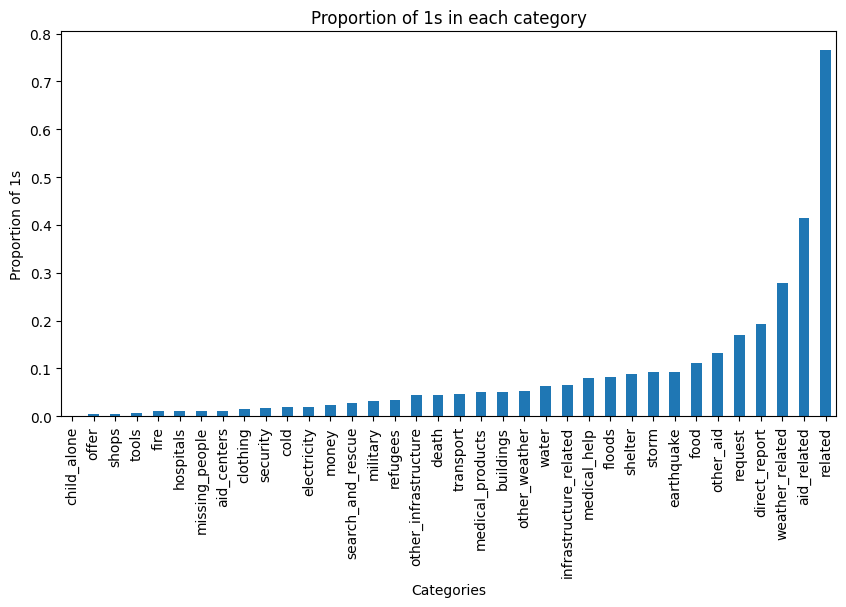

In [6]:
fig, ax = plt.subplots(figsize = (10,5))
y.mean(axis = 0).sort_values().plot(kind = 'bar')
ax.set_xlabel("Categories")
ax.set_ylabel("Proportion of 1s")
ax.set_title("Proportion of 1s in each category")

In [7]:
# remove child_alone as it contains only 1 value
y.drop(columns=['child_alone'], axis=1, inplace=True)

### 2. Write a tokenization function to process your text data

In [8]:
def tokenize(text):
    # First remove punctation and lowercase all letters
    text = re.sub(
        r"[^a-zA-Z0-9]", 
        " ", 
        text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    

    # lemmatize 
    lemmatizer = WordNetLemmatizer()
    
    # clean the tokens
    clean_tokens = []
    for token in tokens:
        clean_token = lemmatizer.lemmatize(token).lower().strip()
        clean_tokens.append(clean_token)
    return clean_tokens

In [9]:
for message in X[:4]:
    tokens = tokenize(message)
    print(message)
    print(tokens, '\n')

Weather update - a cold front from Cuba that could pass over Haiti
['weather', 'update', 'a', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pas', 'over', 'haiti'] 

Is the Hurricane over or is it not over
['is', 'the', 'hurricane', 'over', 'or', 'is', 'it', 'not', 'over'] 

Looking for someone but no name
['looking', 'for', 'someone', 'but', 'no', 'name'] 

UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.
['un', 'report', 'leogane', '80', '90', 'destroyed', 'only', 'hospital', 'st', 'croix', 'functioning', 'need', 'supply', 'desperately'] 



### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [10]:
first_pipeline = Pipeline([
        (
            'vect', 
            CountVectorizer(
                tokenizer = tokenize)),
        (
            'tfidf', 
            TfidfTransformer()),
        (
            'clf', 
            MultiOutputClassifier(
                GradientBoostingClassifier()))
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
def fit_predict(X_train,X_test,y_train,a_pipeline):
    print("We train")
    a_pipeline.fit(X_train, y_train)

    # predict on test data
    print("We predict")
    y_pred = a_pipeline.predict(X_test)

    return a_pipeline, y_pred

In [13]:
%%time
first_pipeline, y_pred_first = fit_predict(X_train,X_test,y_train,first_pipeline)

We train
We predict
CPU times: total: 8min 17s
Wall time: 8min 17s


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [14]:
def results_pipeline(predictions, name_pipeline):
    setup_logger('log_pipeline', f'logs/{name_pipeline}_log.txt')
    logger = logging.getLogger('log_pipeline')

    for idx, column in enumerate(y_test.columns):
        logger.info('feature predicted: ' + column)
        logger.info('-'*53)
        logger.info(classification_report(y_test[column], predictions[:,idx], zero_division = 0))
        logger.info("\n")
    close_logger(logger)

In [15]:
%%time
results_pipeline(y_pred_first, name_pipeline = "first_pipeline")

feature predicted: related
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.22      0.34      1535
           1       0.80      0.97      0.88      5010

    accuracy                           0.80      6545
   macro avg       0.75      0.60      0.61      6545
weighted avg       0.78      0.80      0.75      6545



feature predicted: request
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      5418
           1       0.86      0.52      0.65      1127

    accuracy                           0.90      6545
   macro avg       0.89      0.75      0.80      6545
weighted avg       0.90      0.90      0.89      6545



feature predicted: offer
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   

CPU times: total: 375 ms
Wall time: 334 ms


### 6. Improve your model
Use grid search to find better parameters. 

In [16]:
parameters = {
    'vect__max_df': [0.75, 0.9], # started with 0.75
    'tfidf__sublinear_tf': [False], # started with False
    'clf__estimator__n_estimators' : [10, 100, 500], # started with 500
    'clf__estimator__min_samples_leaf': [1, 2, 5] # started with 1
}    
# Volgende keer n_jobs=6, cv=5, verbose=2
gs_cv = GridSearchCV(
    first_pipeline,
    param_grid=parameters
    )


In [17]:
# fit the grid search
gs_cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x0000016D31107130>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=GradientBoostingClassifier()))]),
             param_grid={'clf__estimator__min_samples_leaf': [1, 2, 5],
                         'clf__estimator__n_estimators': [10, 100, 500],
                         'tfidf__sublinear_tf': [False],
                         'vect__max_df': [0.75, 0.9]})

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [23]:
gs_cv.best_estimator_.steps

[('vect',
  CountVectorizer(max_df=0.75,
                  tokenizer=<function tokenize at 0x0000016D31107130>)),
 ('tfidf', TfidfTransformer()),
 ('clf',
  MultiOutputClassifier(estimator=GradientBoostingClassifier(min_samples_leaf=5,
                                                             n_estimators=500)))]

In [24]:
%%time
results_pipeline(gs_cv.predict(X_test), name_pipeline = "gridsearch_pipeline")

feature predicted: related
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.36      0.48      1535
           1       0.83      0.95      0.89      5010

    accuracy                           0.81      6545
   macro avg       0.77      0.66      0.68      6545
weighted avg       0.80      0.81      0.79      6545



feature predicted: request
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5418
           1       0.82      0.56      0.67      1127

    accuracy                           0.90      6545
   macro avg       0.87      0.77      0.81      6545
weighted avg       0.90      0.90      0.90      6545



feature predicted: offer
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   

CPU times: total: 2.67 s
Wall time: 2.67 s


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [25]:
class TextLengthExtractor(BaseEstimator, TransformerMixin):
    """
    Customized class to add the length of text as a feature.
    This class is used in building model
    """

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_length = pd.Series(X).apply(lambda x: len(x))
        return pd.DataFrame(X_length)

In [26]:
second_pipeline = Pipeline([
        (
            'features', 
            FeatureUnion([
                ('text_pipeline', Pipeline([
                    (
                        'vect', 
                        CountVectorizer(
                            tokenizer = tokenize,
                            max_df=0.75)),
                    ('tfidf', TfidfTransformer(sublinear_tf = False)) ])),
                ('text_length', TextLengthExtractor()) ]
            )),
        (
            'clf', 
            MultiOutputClassifier(
                GradientBoostingClassifier(
                    n_estimators = 500,
                    min_samples_leaf = 1)))
    ])
second_pipeline, second_y_pred = fit_predict(X_train,X_test,y_train,second_pipeline)

We train
We predict


In [27]:
results_pipeline(second_y_pred, name_pipeline = "second_pipeline")

feature predicted: related
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.37      0.49      1535
           1       0.83      0.95      0.89      5010

    accuracy                           0.82      6545
   macro avg       0.77      0.66      0.69      6545
weighted avg       0.81      0.82      0.80      6545



feature predicted: request
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      5418
           1       0.82      0.56      0.66      1127

    accuracy                           0.90      6545
   macro avg       0.87      0.77      0.80      6545
weighted avg       0.90      0.90      0.90      6545



feature predicted: offer
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   

### 9. Export your model as a pickle file

In [29]:
pickle.dump(
    first_pipeline,
    open(
        "../models/first_pipeline.pickle",
        "wb"
    )
)

In [30]:
pickle.dump(
    gs_cv,
    open(
        "../models/gridsearch_pipeline.pickle",
        "wb"
    )
)

In [31]:
pickle.dump(
    second_pipeline,
    open(
        "../models/second_pipeline.pickle",
        "wb"
    )
)

In [32]:
pickle.dump(
    second_pipeline,
    open(
        "../models/preferred_pipeline.pickle",
        "wb"
    )
)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.